### Here I study how to take completeness and measurement error into account when plotting the mass-size relation.

Poor size, SB, total mag measurement affects:

1. Mass-size relation (related to size, total mag, color)
2. UDG distribution profile (only completeness?)
3. Quenched fraction (color, total mag)

In [5]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack
from astropy.coordinates import SkyCoord

In [7]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

#### Load completeness from Greco's detection and vanilla scarlet

In [134]:
import pickle
from scipy.interpolate import interp2d
from scipy.stats import binned_statistic_2d, binned_statistic

In [219]:
x = np.loadtxt(f'./Catalog/Greco_completeness_S18A/completeness-x.txt')
y = np.loadtxt(f'./Catalog/Greco_completeness_S18A/completeness-y.txt')
greco_comp_map = np.loadtxt(f'./Catalog/Greco_completeness_S18A/completeness.txt') / 100

# 2d interpolation
f_greco = interp2d(x, y, greco_comp_map)

# Load vanilla scarlet completeness
with open('./Catalog/completeness/completeness_vanilla_scarlet.pkl', 'rb') as f:
    (deblend_map, _extent, _x_edge, _y_edge) = pickle.load(f)
_range = [_extent[:2], _extent[2:]]

# Coarse grid
detection_map = f_greco((_x_edge[1:] + _x_edge[:-1])
                       / 2, (_y_edge[1:]
                       + _y_edge[:-1]) / 2)

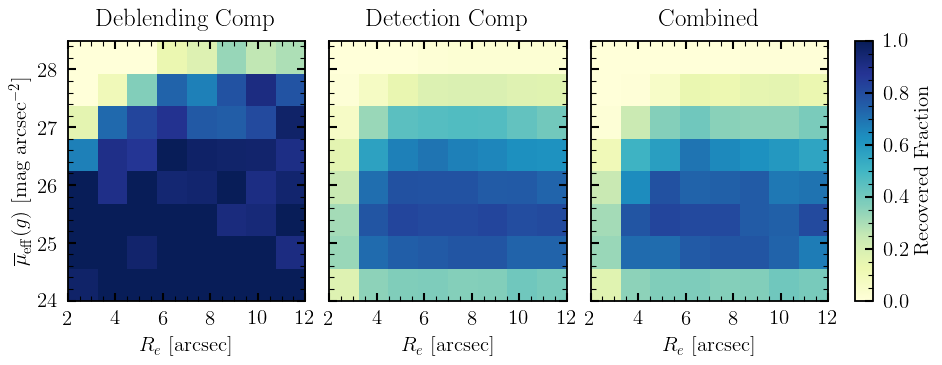

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2.6), sharey=True, sharex=False)

# Deblend + Modeling completeness
plt.sca(axes[0])
im = plt.imshow(deblend_map, 
                extent=_extent, 
                vmin=0, vmax=1, 
                aspect='auto',
                cmap='YlGnBu')
# plt.scatter(R_e, SB_g, color='r', alpha=0.2)

# Greco's detection completeness
plt.sca(axes[1])
plt.imshow(
    detection_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )

# Together
plt.sca(axes[2])
plt.imshow(
    detection_map * deblend_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )
# plt.scatter(R_e, SB_g, color='r', alpha=0.2)


for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')

axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
axes[0].set_title('Deblending Comp')
axes[1].set_title('Detection Comp')
axes[2].set_title('Combined')


fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.1, hspace=0.3)

### A summary distribution of UDGs

combine 0.01 < z < 0.02 and 0.02 < z < 0.04 together

In [50]:
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')
from sample_cuts import post_process_cat

In [220]:
# udg_cat = Table.read('./Catalog/nsa_test.fits')

In [237]:
udg_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz.fits')
# udg_cat = udg_cat[udg_cat['rhalf_spergel'].data > 2.5]

In [238]:
SB_g = udg_cat['SB_eff_avg_g']
SB_g_std = udg_cat['SB_eff_avg_g_err']
R_e = udg_cat['rhalf_spergel']
R_e_std = udg_cat['rhalf_spergel_err']

R_e_phys = udg_cat['rhalf_phys']
R_e_phys_std = udg_cat['rhalf_phys_err']

(array([87., 41., 27.,  8.,  3.,  2.,  4.,  0.,  0.,  2.]),
 array([ 1.99246068,  3.12985676,  4.26725285,  5.40464893,  6.54204501,
         7.6794411 ,  8.81683718,  9.95423326, 11.09162935, 12.22902543,
        13.36642151]),
 [<matplotlib.patches.Polygon at 0x2abbd48cbad0>])

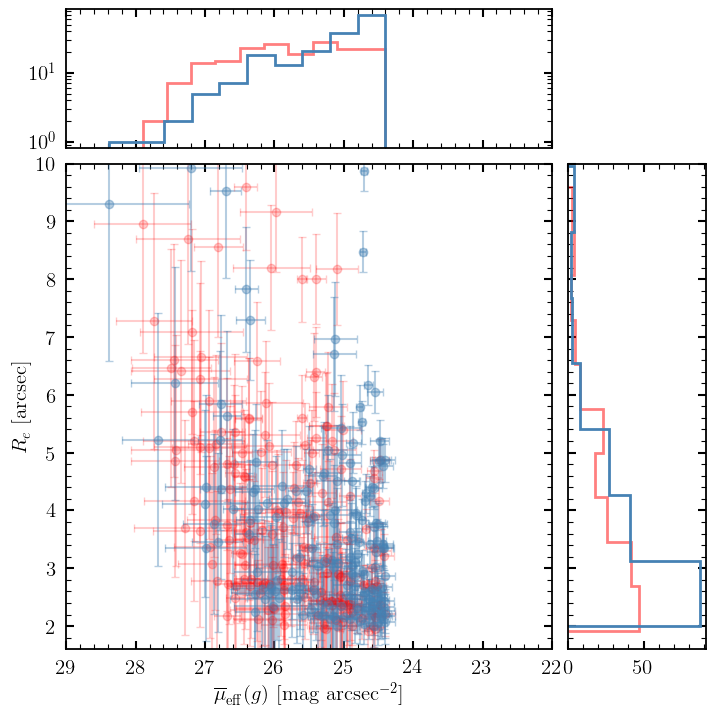

In [239]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]) > 0.8)

ax.errorbar(SB_g[red], 
            R_e[red], 
            xerr=SB_g_std[red], yerr=R_e_std[red],
            fmt='o', color='r', alpha=0.2)

ax.errorbar(SB_g[~red], 
            R_e[~red], 
            xerr=SB_g_std[~red], yerr=R_e_std[~red],
            fmt='o', color='steelblue', alpha=0.4)
ax.set_xlim(29, 22)
ax.set_ylim(1.6, 10)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(SB_g[red], lw=2,
              histtype='step', density=False, color='r', alpha=0.5)
ax_histx.hist(SB_g[~red], lw=2,
              histtype='step', density=False, color='steelblue')
ax_histx.set_yscale('log')
ax_histy.hist(R_e[red], lw=2,
              histtype='step', density=False, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(R_e[~red], lw=2,
              histtype='step', density=False, orientation='horizontal', color='steelblue')
# ax_histy.set_xscale('log')

### Size distribution (after taken measurement error and completeness into account)

In [240]:
_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
area = np.pi * udg_cat['host_r_vir_ang'].data[ind]**2 # deg
print('Total angular area [deg2]:', area.sum())

Total angular area [deg2]: 27.80526572116884


In [63]:
#### Moving average function

In [241]:
def moving_binned_statistic(x, values, x_err=None, statistic='mean', bins=10, range_=None, n_slide=20):
    range_0 = range_
    edges_0 = np.histogram_bin_edges(x, bins=bins, range=range_0)
    delta_x = np.diff(edges_0)[0] / n_slide
    
    output = np.zeros((n_slide, bins))
    cens = np.zeros((n_slide, bins)) # centers
    for k in np.arange(n_slide):
        i = k - n_slide // 2
        _range = range_0 + i * delta_x
        cens[k] = 0.5 * (edges_0[:-1] + edges_0[1:]) + i * delta_x
        if x_err is None:
            output[k] = binned_statistic(x, values, statistic=statistic, bins=bins, range=_range).statistic
        else:
            _x = np.log10(np.abs(10**x + np.random.normal(loc=0, scale=x_err)))
            output[k] = binned_statistic(_x, values, statistic=statistic, bins=bins, range=_range).statistic
        
    return output, cens[len(cens)//2]

In [242]:
n_bins = 8
range_0 = np.array([np.log10(1.5), np.log10(9)])

In [243]:
output, cen = moving_binned_statistic(np.log10(R_e_phys), np.log10(R_e_phys), #x_err=R_e_phys_std,
                                      bins=n_bins, range_=range_0, statistic='count', n_slide=30)
n_cen = np.nanmean(output, axis=0) / area.sum()
n_std = np.nanstd(output, axis=0) / area.sum()

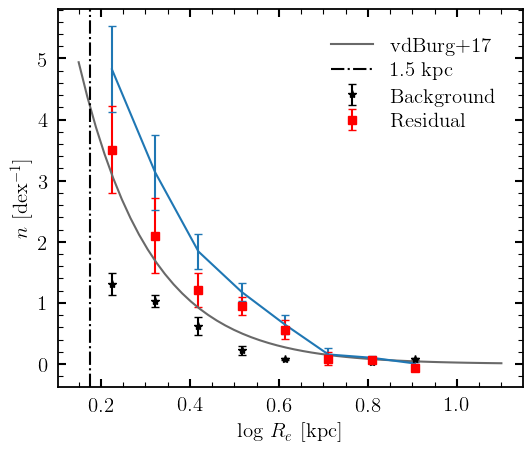

In [244]:
plt.errorbar(cen, n_cen, yerr=n_std)

_temp = np.load('./Catalog/completeness/bkg_size.npy')
cen, n_cen_bkg, n_std_bkg = list(_temp)
plt.errorbar(cen, n_cen_bkg, yerr=n_std_bkg, fmt='*k', 
             markersize=6, label='Background')


plt.errorbar(cen, n_cen - n_cen_bkg, yerr=n_std, fmt='sr', 
             markersize=6, label='Residual')

x = np.linspace(0.15, 1.1)
plt.plot(x, 10**(-2.71 * x + 1.1), color='dimgray', label='vdBurg+17')
plt.axvline(np.log10(1.5), ls='-.', color='k', label='1.5 kpc')

plt.xlabel(r'$\log\,R_e\ [\rm kpc]$')
plt.ylabel(r'$n\ [\rm dex^{-1}]$')
plt.legend()
# plt.yscale('log')

In [181]:
output, cen = moving_binned_statistic(np.log10(R_e_phys), udg_cat['completeness'], #x_err=R_e_phys_std,
                                      bins=n_bins, range_=range_0, statistic=np.nanmean, n_slide=30)
comp_avg = np.nanmean(output, axis=0)
comp_std = np.nanstd(output, axis=0)

# angular size
output, cen = moving_binned_statistic(np.log10(R_e_phys), R_e, #x_err=R_e_phys_std,
                                      bins=n_bins, range_=range_0, statistic=np.nanmean, n_slide=30)
re_cen = np.nanmean(output, axis=0)
re_std = np.nanstd(output, axis=0)

(-0.1, 4.0)

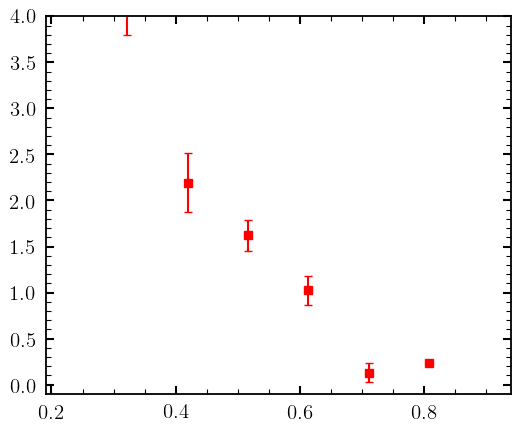

In [182]:
plt.errorbar(cen, (n_cen - n_cen_bkg) / comp_avg, yerr=np.sqrt(n_std**2 + n_std_bkg**2), fmt='sr', 
             markersize=6, label='Residual')

plt.ylim(-0.1, 4)

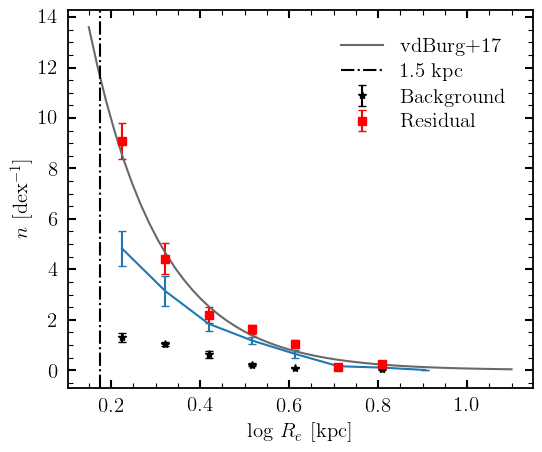

In [183]:
plt.errorbar(cen, n_cen, yerr=n_std)

_temp = np.load('./Catalog/completeness/bkg_size.npy')
cen, n_cen_bkg, n_std_bkg = list(_temp)


plt.errorbar(cen[:-1], n_cen_bkg[:-1], 
             yerr=n_std_bkg[:-1], fmt='*k', 
             markersize=6, label='Background')

plt.errorbar(cen[:-1], (n_cen - n_cen_bkg)[:-1] / comp_avg[:-1], 
             yerr=np.sqrt(n_std**2 + n_std_bkg**2)[:-1], fmt='sr', 
             markersize=6, label='Residual')

x = np.linspace(0.15, 1.1)
plt.plot(x, 10**(-2.71 * x + 1.54), color='dimgray', label='vdBurg+17')
plt.axvline(np.log10(1.5), ls='-.', color='k', label='1.5 kpc')

plt.xlabel(r'$\log\,R_e\ [\rm kpc]$')
plt.ylabel(r'$n\ [\rm dex^{-1}]$')
plt.legend()
# plt.yscale('log')

Text(0, 0.5, '$R_e$ [arcsec]')

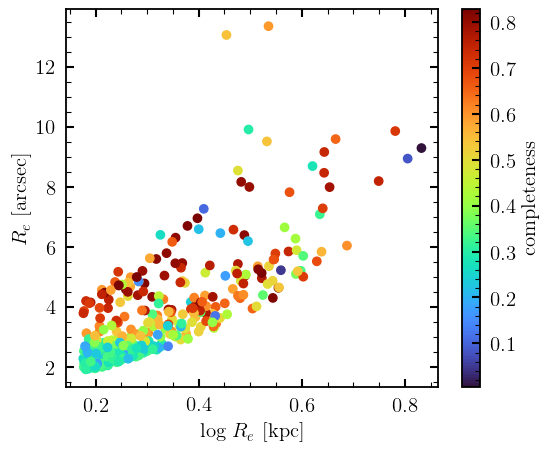

In [184]:
plt.scatter(np.log10(R_e_phys), R_e, c=udg_cat['completeness'])
plt.colorbar(label='completeness')
plt.xlabel('log $R_e$ [kpc]')
plt.ylabel('$R_e$ [arcsec]')

Text(0, 0.5, '$R_e$ [arcsec]')

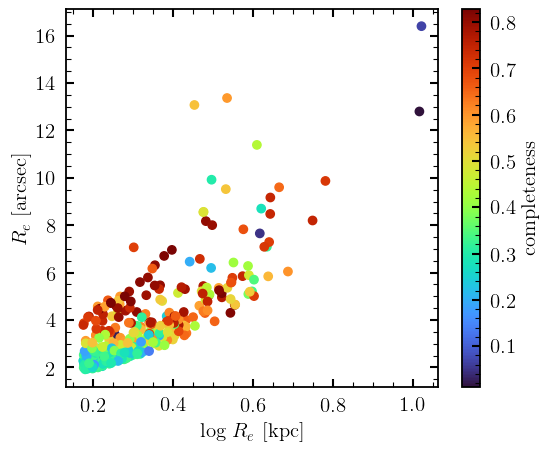

In [378]:
plt.scatter(np.log10(R_e_phys), R_e, c=udg_cat['completeness'])
plt.colorbar(label='completeness')
plt.xlabel('log $R_e$ [kpc]')
plt.ylabel('$R_e$ [arcsec]')

color-code with angular size 

cut at 2.5 arcsec

host: with UDG or not

## Mass-size relation

1. Mass problem with M/L? (Into & Portinari (2013), as described further in Carlsten et al. (2021b).)
We take the solar absolute magnitude in g to be 5.03 for g-filter (Willmer 2018, although there's not data for HSC filters).

$$
\begin{aligned}
&\log \left(M_{\star} / L_{g}\right)=1.774(g-r)-0.783 \\
&\log \left(M_{\star} / L_{g}\right)=1.297(g-i)-0.855
\end{aligned}
$$

In [245]:
log_m_star = udg_cat['log_m_star']
gi_color = udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]

(6.8, 9.2)

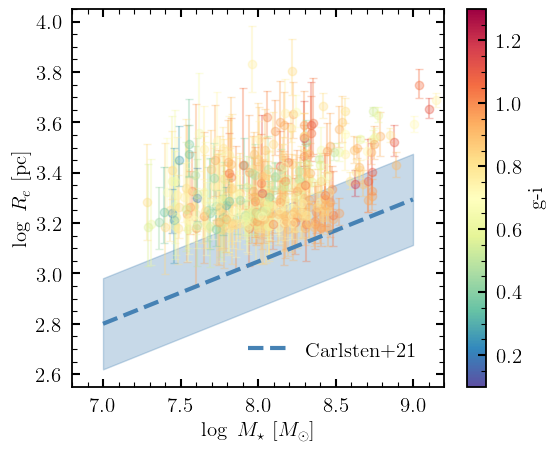

In [246]:
import matplotlib
from matplotlib.colors import Normalize

norm = Normalize(vmin=0.1, vmax=1.3)
cmap = matplotlib.cm.Spectral_r
sm = matplotlib.cm.ScalarMappable(norm, cmap)
sm.set_array([])
_colors = sm.to_rgba(gi_color)

yerrs = np.array([np.log10(R_e_phys + R_e_phys_std) - np.log10(R_e_phys), 
         np.log10(R_e_phys) - np.log10(R_e_phys - R_e_phys_std)])

for i,_ in enumerate(log_m_star):
    sct = plt.errorbar(
        log_m_star[i], 
        np.log10(R_e_phys[i]) + 3, # in pc
#         xerr=log_m_star_std[i],
        yerr=yerrs[:, i].reshape(-1, 1),
        color=_colors[i],
        fmt='o', alpha=0.35)
plt.colorbar(sm, label='g-i')

# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ R_{e}\ [\rm pc]$')
plt.legend(loc='lower right')

plt.xlim(6.8, 9.2)

### Quenched fraction figure: meas error, completeness, etc.

In [247]:
# distance to host
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord).to(u.deg).value
dist_vir = dist / udg_cat['host_r_vir_ang'].data

In [248]:
# flag = udg_cat['host_z'] > 0.025
flag = np.ones_like(udg_cat['host_z']).data.astype(bool)

In [255]:
red = (gi_color > 0.8)
y = red[flag].astype(float)# * udg_cat['weights'][flag].data #/ udg_cat['completeness'][flag].data
quench_frac, edges, _ = binned_statistic(log_m_star[flag], y, 
                                             statistic='mean', range=(7, 9), bins=12)
num, edges, _ = binned_statistic(log_m_star[flag], y, 
                                             statistic='count', range=(7, 9), bins=12)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

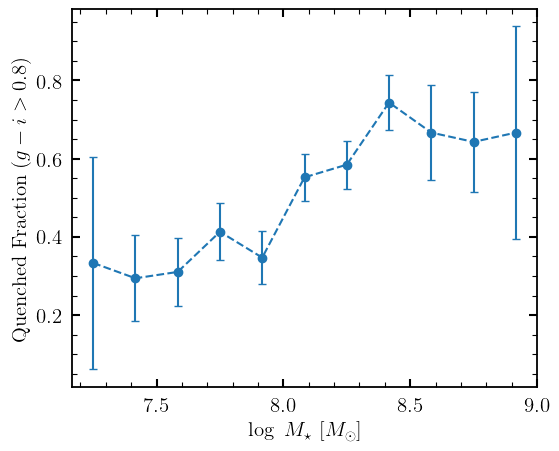

In [256]:
plt.errorbar((edges[:-1] + edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

Quenched fraction as a function of UDG stellar mass

In [79]:
red = (gi_color > 0.7)
identity = np.ones_like(red)

n_bins = 8

edges = np.histogram_bin_edges(log_m_star, bins=n_bins, range=(7, 9))
quench_frac = []
dist2host = []
for i in range(1, n_bins+1):
    flag = np.digitize(log_m_star, edges) == i
    r = np.average(red.astype(float)[flag], weights=(1/udg_cat['completeness'])[flag]) if np.sum(flag) > 0 else np.nan
    quench_frac.append(r)
    
    r = np.average(dist_vir[flag], weights=(1 / udg_cat['completeness'])[flag]) if np.sum(flag) > 0 else np.nan
    dist2host.append(r)
    
quench_frac = np.array(quench_frac)
dist2host = np.array(dist2host)
    
num, _, _ = binned_statistic(log_m_star, 1 / udg_cat['completeness'], statistic='sum', range=(7, 9), bins=n_bins)

_cen = (edges[:-1] + edges[1:]) / 2

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

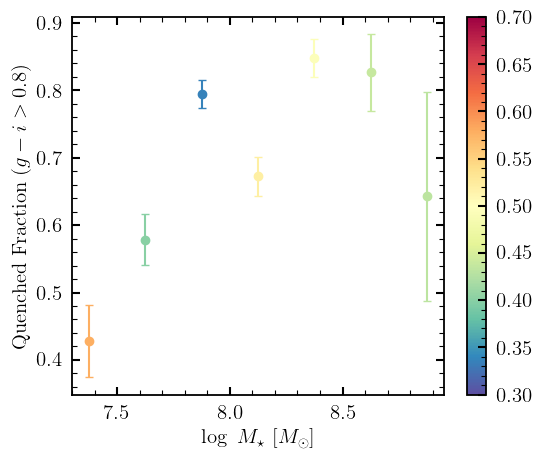

In [80]:
norm = Normalize(vmin=0.3, vmax=0.7)
cmap = matplotlib.cm.Spectral_r
sm = matplotlib.cm.ScalarMappable(norm, cmap)
sm.set_array([])
_colors = sm.to_rgba(dist2host)

for i in range(len(quench_frac)):
    plt.errorbar(_cen[i], 
                 quench_frac[i], 
                 yerr=np.sqrt(quench_frac * (1 - quench_frac) / num)[i], 
                 color=_colors[i],
                 fmt='o')

plt.colorbar(sm)

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

Quenched fraction as a function of **host** stellar mass

In [29]:
red = (gi_color > 0.8)
identity = np.ones_like(red)

n_bins = 8

edges = np.histogram_bin_edges(M_g, bins=n_bins, range=(10.2, 11.2))
quench_frac = []
dist2host = []
for i in range(1, n_bins+1):
    flag = np.digitize(udg_cat['host_stellar_mass'], edges) == i
    r = np.average(red.astype(float)[flag], weights=(1/comp)[flag]) if np.sum(flag) > 0 else np.nan
    quench_frac.append(r)
    
    r = np.average(dist_vir[flag], weights=(1 / comp)[flag]) if np.sum(flag) > 0 else np.nan
    dist2host.append(r)
    
quench_frac = np.array(quench_frac)
dist2host = np.array(dist2host)
    
num, _, _ = binned_statistic(udg_cat['host_stellar_mass'], 1 / comp, 
                             statistic='sum', 
                             range=(10.2, 11.2), bins=n_bins)

_cen = (edges[:-1] + edges[1:]) / 2

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

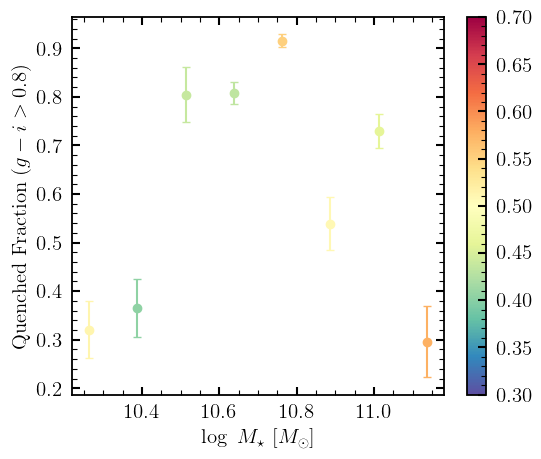

In [30]:
norm = Normalize(vmin=0.3, vmax=0.7)
cmap = matplotlib.cm.Spectral_r
sm = matplotlib.cm.ScalarMappable(norm, cmap)
sm.set_array([])
_colors = sm.to_rgba(dist2host)

for i in range(len(quench_frac)):
    plt.errorbar(_cen[i], 
                 quench_frac[i], 
                 yerr=np.sqrt(quench_frac * (1 - quench_frac) / num)[i], 
                 color=_colors[i],
                 fmt='o')

plt.colorbar(sm)

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

projected radius
red near contamination

---

In [31]:
yagi_cat = Table.read('./Catalog/Yagi+16.fits')

In [32]:
flag = (yagi_cat['Re1'].data.data > 1.5)# & (yagi_cat['SuBr0'].data.data > 24.5)
yagi_cat = yagi_cat[flag]

In [33]:
yagi_cat['log_m_star'] = (4.83 - yagi_cat['Rmag1'] + 35.05) / (2.5)

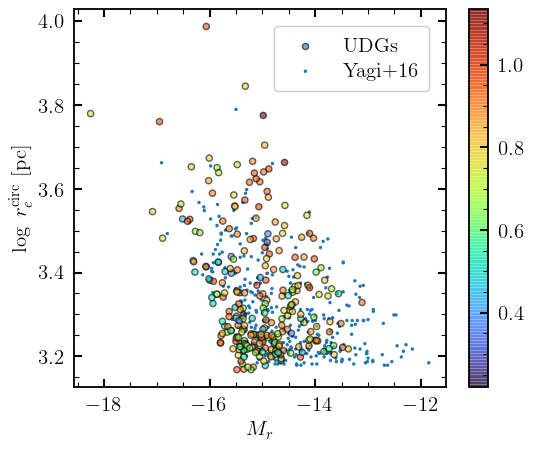

In [34]:
sct = plt.scatter(udg_cat['abs_mag'][:, 1], 
            np.log10(R_e_phys) + 3, 
            c=gi_color, s=20,
                  alpha=0.6, edgecolors='k',
            label='UDGs')
plt.colorbar()

#x = np.linspace(7, 9)
# plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
#                  mass_size_carlsten(x) + 0.181, 
#                  color='steelblue', alpha=0.3)
# plt.plot(x, mass_size_carlsten(x), ls='--', 
#          color='steelblue', lw=3, label='Carlsten+21')


plt.scatter(yagi_cat['Rmag1'] - 35.05, np.log10(yagi_cat['Re1']) + 3, 
            label='Yagi+16', edgecolor='none', s=6, zorder=0)

plt.xlabel(r'$M_r$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(frameon=True)

### Spatial distribution

In [150]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw

cosmology.setCosmology('planck15')
p_nfw = profile_nfw.NFWProfile(M=1e10, c=10.0, z=0.0, mdef='vir')
# sigmas = p_nfw.surfaceDensity(rs)

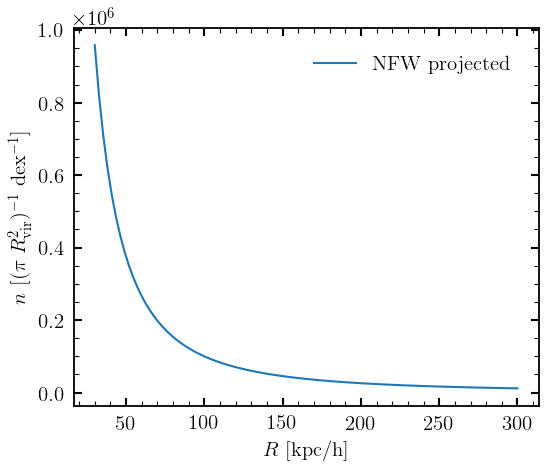

In [231]:
plt.plot(rs, sigmas, label='NFW projected')

plt.xlabel(r'$R\ [\rm kpc/h]$')
plt.ylabel(r'$n\ [(\pi\ R_{\rm vir}^2)^{-1}\ \rm dex^{-1}]$')

plt.legend()

In [151]:
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)

dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

In [152]:
# weights = 1 / (np.pi * (udg_cat['host_r_vir'].data / 300)**2)

In [210]:
weights = 1 / udg_cat['completeness']

n, bins = np.histogram(dist_ratio * 300, weights=weights, bins=8)

contam_density = 4.10625 # per deg2
contam_profile = np.array([
    contam_density * np.diff(np.pi * (bins / udg_cat['host_ang_diam_dist'].data[i])**2) for i in range(len(udg_cat))
])
# contam_profile = contam_profile.mean(axis=0)

In [198]:
n -= 4 * contam_profile
bin_cen = (bins[1:] + bins[:-1]) / 2

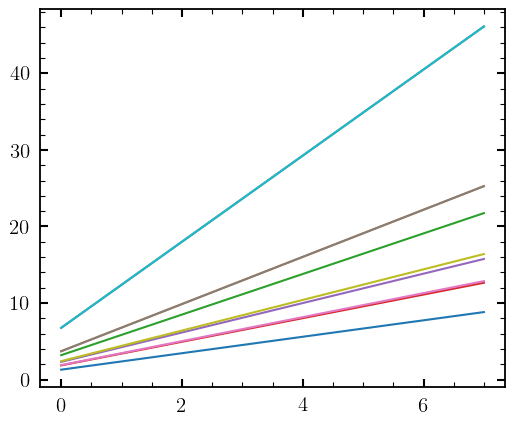

In [214]:
plt.plot(contam_profile[:10].T)

In [204]:
p_nfw = profile_nfw.NFWProfile(M=1e11, c=5.0, z=0.0, mdef='vir')
res = p_nfw.fit(bin_cen, n, quantity='Sigma', method='leastsq')

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 43 steps. Best-fit parameters:
Parameter       rhos = 1.28e+00 [8.42e-01 .. 1.96e+00]
Parameter         rs = 1.18e+02 [9.46e+01 .. 1.46e+02]
chi2 / Ndof = 1465.3 / 6 = 244.22
-------------------------------------------------------------------------------------


In [205]:
300 / res['x'][1]

2.5509312872909846

In [206]:
p_nfw = profile_nfw.NFWProfile(rs=res['x'][1], rhos=res['x'][0], mdef = 'vir')
rs = np.linspace(0.1, 1, 100) * 300
sigmas = p_nfw.surfaceDensity(rs)

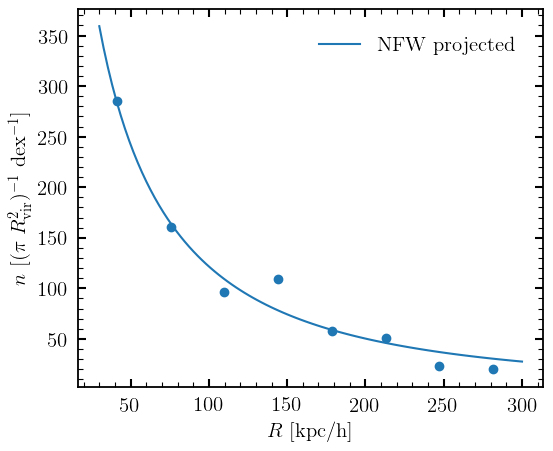

In [207]:
plt.scatter(bin_cen, n)
plt.plot(rs, sigmas, label='NFW projected')

plt.xlabel(r'$R\ [\rm kpc/h]$')
plt.ylabel(r'$n\ [(\pi\ R_{\rm vir}^2)^{-1}\ \rm dex^{-1}]$')

plt.legend()

(array([232.1987256 , 161.47015016, 117.59296103, 123.22316302,
        112.34740522,  88.63416313,  70.41730092,  97.79862889,
         57.94746809,  75.30721696]),
 array([0.0802539 , 0.17176368, 0.26327345, 0.35478323, 0.44629301,
        0.53780278, 0.62931256, 0.72082234, 0.81233211, 0.90384189,
        0.99535167]),
 <BarContainer object of 10 artists>)

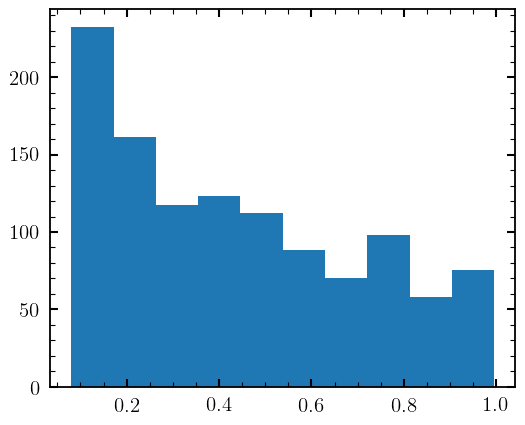

In [159]:
plt.hist(dist_ratio, weights=weights)